In [68]:
import glob

data_folder = r'Datasets\TabularIoTAttacks-2024'
data_files = glob.glob(data_folder + '/*.csv')

In [69]:
data_files

['Datasets\\TabularIoTAttacks-2024\\Benign Traffic_2.csv',
 'Datasets\\TabularIoTAttacks-2024\\DDoS ICMP Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\DDoS UDP Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\DoS ICMP Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\DoS TCP Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\DoS UDP Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\MITM ARP Spoofing.csv',
 'Datasets\\TabularIoTAttacks-2024\\MQTT DDoS Publish Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\MQTT DoS Connect Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\MQTT DoS Publish Flood.csv',
 'Datasets\\TabularIoTAttacks-2024\\MQTT Malformed.csv',
 'Datasets\\TabularIoTAttacks-2024\\Recon OS Scan.csv',
 'Datasets\\TabularIoTAttacks-2024\\Recon Ping Sweep.csv',
 'Datasets\\TabularIoTAttacks-2024\\Recon Port Scan.csv',
 'Datasets\\TabularIoTAttacks-2024\\Recon Vulnerability Scan.csv']

In [70]:
selected_attacks = ['DoS TCP Flood', 'Recon Port Scan', 'MQTT DDoS Publish Flood', 'MQTT DoS Connect Flood', 'Benign Traffic']
selected_files = [file for file in data_files if any(attack in file for attack in selected_attacks)]

In [71]:
from data_preprocessing import create_datasets
from model import LSTMModel
from train import train_and_evaluate
import joblib

file_names = selected_files
window_size = 1  # The size of the window
batch_size = 1024

# Try to load existing encoder (if you saved it previously)
encoder_path = "label_encoder.pkl"
scaler_path = "scaler.pkl"
model_path = "lstm_model.pth"
label_encoder = None
scaler = None

try:
    label_encoder = joblib.load(encoder_path)
    scaler = joblib.load(scaler_path)
    print("Loaded existing encoder and scaler.")
except:
    print("No pre-existing encoder/scaler found. Creating new ones.")


# Prepare the data
train_loader, val_loader, test_loader, scaler, label_encoder, dataset = create_datasets(file_names, 
                                                                                        window_size, label_encoder=label_encoder, 
                                                                                        scaler=scaler,
                                                                                        batch_size=batch_size)


# Initialize the LSTM model
input_size = train_loader.dataset[0][0].shape[1]  # Number of features
hidden_size = input_size // 2
num_classes = len(label_encoder.classes_)  # Number of unique attack names

No pre-existing encoder/scaler found. Creating new ones.


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:56<00:00, 11.34s/it]


In [72]:
from collections import Counter

train_labels = [label for _, label in train_loader.dataset]
test_labels = [label for _, label in test_loader.dataset]
val_labels = [label for _, label in val_loader.dataset]
Counter(train_labels), Counter(test_labels), Counter(val_labels)

(Counter({np.int64(1): 1517102,
          np.int64(4): 349365,
          np.int64(2): 298180,
          np.int64(3): 171208,
          np.int64(0): 23585}),
 Counter({np.int64(1): 421034,
          np.int64(4): 97451,
          np.int64(2): 82675,
          np.int64(3): 47805,
          np.int64(0): 6436}),
 Counter({np.int64(1): 168780,
          np.int64(4): 38706,
          np.int64(2): 33058,
          np.int64(3): 19018,
          np.int64(0): 2599}))

In [73]:
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
epochs = 10
# Train and evaluate the model
model_save_path, encoder_save_path, scaler_save_path = train_and_evaluate(model, train_loader, val_loader, test_loader, dataset, 
                   model_save_path=model_path, 
                   encoder_save_path=encoder_path, 
                   scaler_save_path=scaler_path,
                   epochs=epochs,
                   windows_size=window_size)


2024-12-10 12:02:34,503 - INFO - Epoch [1/10] training started.
Epoch 1/10: 100%|██████████| 2305/2305 [01:19<00:00, 29.00batch/s, accuracy=95.9, loss=0.119]
2024-12-10 12:03:53,997 - INFO - Epoch [1/10] training completed. Loss: 0.1188, Accuracy: 95.88%
2024-12-10 12:03:53,999 - INFO - Epoch [1/10] validation started.
Validating: 100%|██████████| 257/257 [00:08<00:00, 32.02batch/s, accuracy=99.8]
2024-12-10 12:04:02,031 - INFO - Epoch [1/10] validation completed. Accuracy: 99.77%
2024-12-10 12:04:02,032 - INFO - Epoch [2/10] training started.
Epoch 2/10: 100%|██████████| 2305/2305 [01:20<00:00, 28.61batch/s, accuracy=99.8, loss=0.00748]
2024-12-10 12:05:22,594 - INFO - Epoch [2/10] training completed. Loss: 0.0075, Accuracy: 99.82%
2024-12-10 12:05:22,595 - INFO - Epoch [2/10] validation started.
Validating: 100%|██████████| 257/257 [00:07<00:00, 32.81batch/s, accuracy=99.9]
2024-12-10 12:05:30,436 - INFO - Epoch [2/10] validation completed. Accuracy: 99.88%
2024-12-10 12:05:30,439 - 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6436
           1       1.00      1.00      1.00    421034
           2       1.00      1.00      1.00     82675
           3       1.00      1.00      1.00     47805
           4       1.00      1.00      1.00     97451

    accuracy                           1.00    655401
   macro avg       1.00      1.00      1.00    655401
weighted avg       1.00      1.00      1.00    655401



In [74]:
model

LSTMModel(
  (lstm): LSTM(80, 40, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=40, out_features=5, bias=True)
)

In [75]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Load the LabelEncoder from the .pkl file
label_encoder = joblib.load(encoder_save_path) # type: LabelEncoder

# Example usage
classes = label_encoder.classes_ # type: list
print("Loaded classes:", classes)



Loaded classes: ['Benign Traffic' 'DoS TCP Flood' 'MQTT DDoS Publish Flood'
 'MQTT DoS Connect Flood' 'Recon Port Scan']


In [76]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
correct_test = 0
total_test = 0
all_labels = []
all_preds = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for inputs, labels in pbar_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Accumulate results for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            pbar_test.set_postfix(accuracy=100 * correct_test/total_test)

test_accuracy = 100 * correct_test / total_test

# Print the classification report
report = classification_report(all_labels, all_preds)


Testing: 100%|██████████| 641/641 [00:19<00:00, 33.53batch/s, accuracy=99.9]


Counter({np.int64(1): 421034,
         np.int64(4): 97451,
         np.int64(2): 82675,
         np.int64(3): 47805,
         np.int64(0): 6436})

In [77]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9998    1.0000    0.9999      6436
           1     0.9995    0.9998    0.9997    421034
           2     0.9986    0.9987    0.9986     82675
           3     0.9982    0.9976    0.9979     47805
           4     0.9998    0.9988    0.9993     97451

    accuracy                         0.9993    655401
   macro avg     0.9992    0.9990    0.9991    655401
weighted avg     0.9993    0.9993    0.9993    655401



In [78]:
print(classification_report(all_labels, all_preds, digits=4, target_names=label_encoder.classes_))

                         precision    recall  f1-score   support

         Benign Traffic     0.9998    1.0000    0.9999      6436
          DoS TCP Flood     0.9995    0.9998    0.9997    421034
MQTT DDoS Publish Flood     0.9986    0.9987    0.9986     82675
 MQTT DoS Connect Flood     0.9982    0.9976    0.9979     47805
        Recon Port Scan     0.9998    0.9988    0.9993     97451

               accuracy                         0.9993    655401
              macro avg     0.9992    0.9990    0.9991    655401
           weighted avg     0.9993    0.9993    0.9993    655401



In [79]:
label_idxs = [0, 4, 7, 8, 13]

In [80]:
print(classification_report(all_labels, all_preds, digits=4, labels=label_idxs, target_names=[classes[i] for i in label_idxs]))

IndexError: index 7 is out of bounds for axis 0 with size 5

In [ ]:
label_idxs = [0, 4, 7, 8, 11, 13]
print(classification_report(all_labels, all_preds, digits=4, labels=label_idxs, target_names=[classes[i] for i in label_idxs]))

                         precision    recall  f1-score   support

         Benign Traffic     0.9984    1.0000    0.9992       612
          DoS TCP Flood     0.9998    0.9994    0.9996     42343
MQTT DDoS Publish Flood     0.9990    0.9976    0.9983      8244
 MQTT DoS Connect Flood     0.9848    0.9985    0.9916      4660
          Recon OS Scan     0.7006    0.6414    0.6697      1704
        Recon Port Scan     0.9393    0.9611    0.9500      9685

              micro avg     0.9828    0.9845    0.9837     67248
              macro avg     0.9370    0.9330    0.9347     67248
           weighted avg     0.9824    0.9845    0.9834     67248



In [83]:
import pandas as pd

df = pd.DataFrame({'True': all_labels, 'Predicted': all_preds})

In [86]:
df['True'] = label_encoder.inverse_transform(df['True'])    

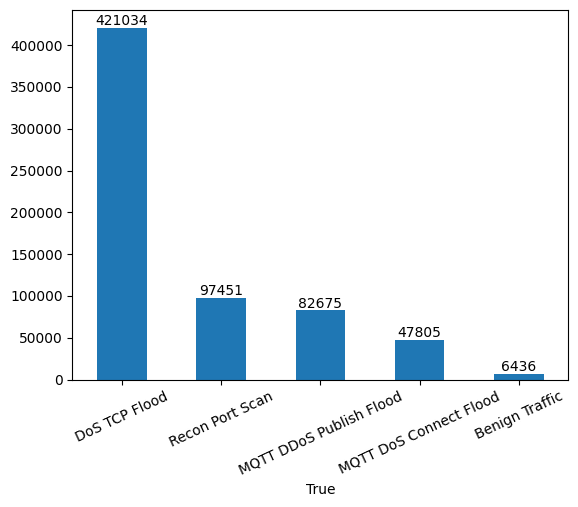

In [89]:
import matplotlib.pyplot as plt

ax = df['True'].value_counts().plot(kind='bar')

# Add annotations for each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Rotate X-axis labels
plt.xticks(rotation=25)

# Show the plot
plt.show()


In [91]:
df = pd.DataFrame({'Label': dataset.labels})

In [93]:
df['Label'] = label_encoder.inverse_transform(df['Label'])

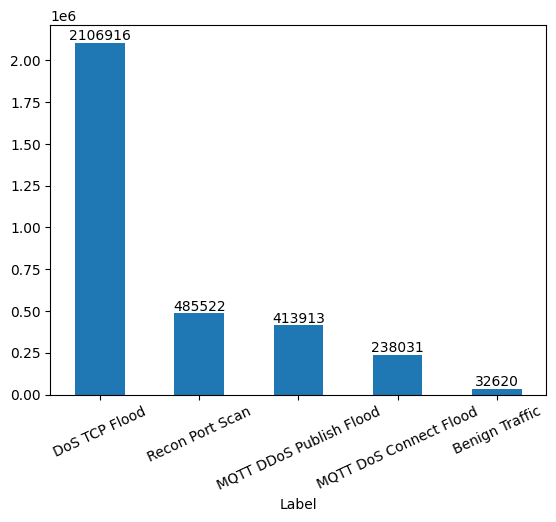

In [94]:
import matplotlib.pyplot as plt

ax = df['Label'].value_counts().plot(kind='bar')

# Add annotations for each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Rotate X-axis labels
plt.xticks(rotation=25)

# Show the plot
plt.show()
